In [1]:
import os
import sys
import glob

import librosa
import numpy as np
from scipy.optimize import curve_fit
from pystoi import stoi
from pysiib import SIIB
import matplotlib.pyplot as plt

repos_dir = r'/home/akikun/repos'
#repos_dir = r'/home/takkan/repos'
sys.path.append(repos_dir)
sys.path.append(os.path.join(repos_dir, 'Intelligibility-MetricGAN'))
import audio_util as au
from sak import signal_processing as sp
from sak import nele

In [2]:
# directories.
train_dir = r'/home/common/db/audio_corpora/nele/imgan/train_small'
train_clean_dir = os.path.join(train_dir, 'clean')
train_noise_dir = os.path.join(train_dir, 'noise-8')
train_enhanced_dir = os.path.join(train_dir, 'enhanced')

## check the original implementation in audio_util.py

In [ ]:
def read_STOI(clean_file, noise_file, enhanced_file):
    clean_wav    = sp.load_wav(clean_file)
    noise_wav    = sp.load_wav(noise_file)     
    enhanced_wav = sp.load_wav(enhanced_file)
    
    minL = min(len(clean_wav),len(enhanced_wav))
    clean_wav = clean_wav[:minL]
    noise_wav = noise_wav[:minL]
    enhanced_wav = enhanced_wav[:minL]
    
    stoi_score = stoi(clean_wav, enhanced_wav + noise_wav, 44100, extended=True) * 2    
    return stoi_score


def read_SIIB(clean_file, noise_file, enhanced_file):
    clean_wav    = sp.load_wav(clean_file)     
    noise_wav    = sp.load_wav(noise_file)     
    enhanced_wav = sp.load_wav(enhanced_file)
    
    minL = min(len(clean_wav),len(enhanced_wav))
    clean_wav = clean_wav[:minL]
    noise_wav = noise_wav[:minL]
    enhanced_wav = enhanced_wav[:minL]
    
    siib_score = au.SIIB_Wrapper_ger(clean_wav, enhanced_wav + noise_wav, 44100)  
    return siib_score

In [ ]:
train_clean_paths = glob.glob(os.path.join(train_clean_dir, '*.wav'))
train_clean_paths.sort()
stoi_list = []
siib_list = []

for train_clean_path in train_clean_paths[0:3]:
    train_noise_path = os.path.join(train_noise_dir, os.path.basename(train_clean_path))
    train_enhanced_path = os.path.join(train_enhanced_dir, os.path.basename(train_clean_path))
    
    stoi_score = read_STOI(train_clean_path, train_noise_path, train_enhanced_path)
    siib_score = read_SIIB(train_clean_path, train_noise_path, train_enhanced_path)
    print('STOI = ' + str(stoi_score) + ', SIIB = ' + str(siib_score))
    
    stoi_list.append(stoi_score)
    siib_list.append(siib_score)

In [ ]:
print('average STOI = ' + str(sum(stoi_list) / len(stoi_list)) + 
      ', max SIIB = ' + str(max(stoi_list)) + 
      ', min SIIB = ' + str(min(stoi_list)))
print('aberage SIIB = ' + str(sum(siib_list) / len(siib_list)) + 
      ', max STOI = ' + str(max(siib_list)) + 
      ', min STOI = ' + str(min(siib_list)))

## implement functions for JR projects.

In [28]:
def logistic_function(x, a, b):
    y = 1/(1+np.exp(-a*(x-b)))
    return y


def mapping_func_jr(x):
    y = 1/(1+np.exp(-14.83*(x+0.66)))


def SIIB_Wrapper_jr(x,y,fs):
    minL = min(len(x),len(y))
    x = x[:minL]
    y = y[:minL]
    M = len(x)/fs
    if(M<20):
        x = np.hstack([x]*round(50/M))
        y = np.hstack([y]*round(50/M))
    #return mapping_func_jr(SIIB(x,y,fs,gauss=True))
    return SIIB(x,y,fs,gauss=True)

    
def read_SIIB_jr(clean_file, noise_file, enhanced_file, sampling_frequency=44100):
    clean_wav    = sp.load_wav(clean_file)     
    noise_wav    = sp.load_wav(noise_file)     
    enhanced_wav = sp.load_wav(enhanced_file)
    
    minL = min(len(clean_wav),len(enhanced_wav))
    clean_wav = clean_wav[:minL]
    noise_wav = noise_wav[:minL]
    enhanced_wav = enhanced_wav[:minL]
    
    siib_score = SIIB_Wrapper_jr(clean_wav, enhanced_wav + noise_wav, sampling_frequency)  
    return siib_score

In [35]:
def calc_siib_file(wav_clean_path, wav_noise_path, wav_enhanced_path, sampling_frequency=44100):
    wav_clean    = sp.load_wav(wav_clean_path)     
    wav_noise    = sp.load_wav(wav_noise_path)     
    wav_enhanced = sp.load_wav(wav_enhanced_path)
            
    minL = min(len(wav_clean),len(wav_enhanced))
    wav_clean    = wav_clean[:minL]
    wav_noise    = wav_noise[:minL]
    wav_enhanced = wav_enhanced[:minL]
    
    wav_mixed = wav_noise + wav_enhanced
    M = len(wav_clean)/sampling_frequency
    if(M < 20):
        wav_clean = np.hstack([wav_clean]*round(50/M))
        wav_mixed = np.hstack([wav_mixed]*round(50/M))
    
    return SIIB(wav_clean, wav_mixed, sampling_frequency, gauss=True) 


def mapping_func_jr(x):
    y = 1/(1+np.exp(-0.066*(x-54)))
    return y


def calc_normalized_siib_file(wav_clean_path, wav_noise_path, wav_enhanced_path, sampling_frequency=44100):
    siib_score = calc_siib_file(
        wav_clean_path, wav_noise_path, wav_enhanced_path, sampling_frequency=sampling_frequency)
    #print(siib_score)
    return siib_score, mapping_func_jr(siib_score)

In [32]:
# wav_clean_path = wav_clean_paths[10]
# wav_noise_path = wav_clean_path.replace(train_clean_dir, train_noise_dir)
# wav_enhanced_path = wav_clean_path.replace(train_clean_dir, train_enhanced_dir)
# x = calc_siib_file(wav_clean_path, wav_noise_path, wav_enhanced_path, sampling_frequency=44100)
# _, y = calc_normalized_siib_file(wav_clean_path, wav_noise_path, wav_enhanced_path, sampling_frequency=44100)
# print(x)
# print(y)

42.77034424165197
42.77034424165197
0.32275113033180075


In [36]:
# check the distribution of SIIB. 
wav_clean_paths = glob.glob(os.path.join(train_clean_dir, '*.wav'))
wav_clean_paths.sort()

siib_y_list = []
siib_x_list = []
for i, wav_clean_path in enumerate(wav_clean_paths[:], start=1):
    wav_basename = os.path.basename(wav_clean_path)
    wav_noise_path = os.path.join(train_noise_dir, wav_basename)
    wav_enhanced_path = os.path.join(train_enhanced_dir, wav_basename)

    print('\r' + '{}/{}'.format(i, len(wav_clean_paths)), end="")
    #stoi_score = read_STOI(train_clean_path, train_noise_path, train_enhanced_path)
    siib_x = calc_siib_file(wav_clean_path, wav_noise_path, wav_enhanced_path)
    _, siib_y = calc_normalized_siib_file(wav_clean_path, wav_noise_path, wav_enhanced_path)
    
    #siib_y_list.append(stoi_score)
    siib_x_list.append(siib_x)
    siib_y_list.append(siib_y)

96/96

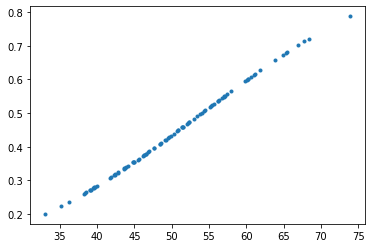

In [38]:
plt.plot(siib_x_list, siib_y_list, '.')

## calculate the appropriate a and b

In [9]:
siib_y_np = np.array(siib_y_list)
siib_x_np = np.array(siib_x_list)
popt, pcov = curve_fit(logistic_function, siib_x_np, siib_y_np)
print(popt)

[1. 1.]


/home/akikun/miniconda3/envs/nele/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [26]:
# why not just calculate a and b analytically?
#np.max(siib_x_list) # 73.8
#np.min(siib_x_list) # 33.0

# so find a and b to map siib 75 --> 0.8, siib 33 --> 0.2.
def calc_a_b(x_1, y_1, x_2, y_2):
    a = np.log((1/y_1 - 1) / (1/y_2 - 1))/(x_2 - x_1)
    b = x_1 + np.log(1/y_1 - 1)/a
    return a, b

a, b = calc_a_b(75, 0.8, 33, 0.2)
print(a)
print(b)

0.06601401719618527
54.0
